# Auxiliary Classifier Generative Adversarial Networks (AC-GAN) on MNIST

Modified from Keras examples:

https://github.com/keras-team/keras/blob/master/examples/mnist_acgan.py

Original repo: https://github.com/lukedeo/keras-acgan

Here, we use the tensorflow backend. The learning rate is decreased.

In [1]:
KERAS_MODEL_FILEPATH = '../../demos/data/mnist_acgan/mnist_acgan.h5'

In [2]:
from PIL import Image
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import Multiply, LeakyReLU, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np

np.random.seed(1337)

Using TensorFlow backend.
/home/leon/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    cnn = Sequential()

    cnn.add(Dense(1024, input_dim=latent_size, activation='relu'))
    cnn.add(Dense(128 * 7 * 7, activation='relu'))
    cnn.add(Reshape((7, 7, 128)))

    # upsample to (..., 14, 14)
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Conv2D(256, 5, padding='same', activation='relu',
                   kernel_initializer='glorot_normal'))

    # upsample to (..., 28, 28)
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Conv2D(128, 5, padding='same', activation='relu',
                   kernel_initializer='glorot_normal'))

    # take a channel axis reduction
    cnn.add(Conv2D(1, 2, padding='same', activation='tanh',
                   kernel_initializer='glorot_normal'))

    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size,))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    # 10 classes in MNIST
    emb = Embedding(10, latent_size, embeddings_initializer='glorot_normal')(image_class)
    cls = Flatten()(emb)

    # hadamard product between z-space and a class conditional embedding
    h = Multiply()([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2, input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(10, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])

In [4]:
# batch and latent size taken from the paper
epochs = 50
batch_size = 100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
# decreased learning rate from repo settings
adam_lr = 0.00005
adam_beta_1 = 0.5

# build the discriminator
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

# build the generator
generator = build_generator(latent_size)
generator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss='binary_crossentropy'
)

In [5]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

In [6]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 12544)        387840      input_1[0][0]                    
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            12545       sequential_1[1][0]               
__________________________________________________________________________________________________
auxiliary (Dense)               (None, 10)           125450      sequential_1[1][0]               
Total params: 525,835
Trainable params: 525,835
Non-trainable params: 0
_____________________________________

In [7]:
latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1, 1]
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)

num_train, num_test = X_train.shape[0], X_test.shape[0]

### training

In [8]:
print('Epoch\tL_s(G)\tL_s(G)\tL_s(D)\tL_s(D)\tL_c(G)\tL_c(G)\tL_c(D)\tL_c(D)')
for epoch in range(epochs):
    print(epoch + 1, end='\t', flush=True)

    num_batches = int(X_train.shape[0] / batch_size)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(num_batches):
        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (batch_size, latent_size))

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, 10, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
        sampled_labels = np.random.randint(0, 10, 2 * batch_size)

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(
            combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))],
                [trick, sampled_labels]
            )
        )

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (num_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, 10, num_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=0)

    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(X, [y, aux_y], verbose=0)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
    sampled_labels = np.random.randint(0, 10, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels],
        verbose=0
    )

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
    
    print('{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(
        # generation loss
        generator_train_loss[1], generator_test_loss[1],
        discriminator_train_loss[1], discriminator_test_loss[1],
        # auxillary loss
        generator_train_loss[2], generator_test_loss[2],
        discriminator_train_loss[2], discriminator_test_loss[2],
    ))

    # save model every epoch
    generator.save(KERAS_MODEL_FILEPATH)

#     # generate some digits to display
#     noise = np.random.uniform(-1, 1, (100, latent_size))

#     sampled_labels = np.array([[i] * 10 for i in range(10)]).reshape(-1, 1)

#     # get a batch to display
#     generated_images = generator.predict([noise, sampled_labels], verbose=0)

#     # arrange them into a grid
#     img = (np.concatenate([r.reshape(-1, 28)
#                            for r in np.split(generated_images, 10)
#                            ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

#     Image.fromarray(img).save('../../demos/data/mnist_acgan/mnist_acgan_generated_{0:03d}.png'.format(epoch))
    
print('done.')

Epoch	L_s(G)	L_s(G)	L_s(D)	L_s(D)	L_c(G)	L_c(G)	L_c(D)	L_c(D)
1	

/home/leon/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1.1100	0.9312	0.5795	0.7355	2.2971	1.2854	1.6925	0.9315
2	1.0730	0.5990	0.6369	0.8421	0.5163	0.1205	0.5372	0.2955
3	1.1886	0.8601	0.5789	0.6166	0.1651	0.0631	0.3060	0.2019
4	1.2439	0.9160	0.5571	0.4781	0.1322	0.0678	0.2684	0.1844
5	1.2500	0.7964	0.5549	0.6434	0.1182	0.0712	0.2339	0.1710
6	1.2235	1.0951	0.5536	0.5279	0.0581	0.0745	0.1744	0.1409
7	1.0737	1.2428	0.6150	0.5226	0.0483	0.0046	0.1400	0.0813
8	0.9644	0.9570	0.6262	0.5729	0.0208	0.0086	0.1069	0.0717
9	0.9787	0.7053	0.6365	0.7311	0.0234	0.0086	0.0990	0.0628
10	0.9373	0.7018	0.6392	0.6134	0.0175	0.0028	0.0875	0.0541
11	0.8988	0.8082	0.6409	0.5941	0.0157	0.0010	0.0796	0.0480
12	0.8516	0.7033	0.6608	0.6815	0.0122	0.0092	0.0707	0.0479
13	0.8081	0.7507	0.6802	0.7611	0.0116	0.0074	0.0681	0.0461
14	0.7778	0.7105	0.6895	0.6852	0.0113	0.0051	0.0662	0.0425
15	0.7542	0.6691	0.6919	0.6839	0.0092	0.0033	0.0610	0.0375
16	0.7228	0.7059	0.7044	0.6954	0.0078	0.0032	0.0566	0.0359
17	0.7198	0.6816	0.7035	0.7041	0.0067	0.0147	0.0536	0.0381
18	0.712

### generate

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def make_digit(digit=None):
    noise = np.random.uniform(-1, 1, (1, latent_size))

    sampled_label = np.array([
            digit if digit is not None else np.random.randint(0, 10, 1)
        ]).reshape(-1, 1)

    generated_image = generator.predict(
        [noise, sampled_label], verbose=0)

    return np.squeeze((generated_image * 127.5 + 127.5).astype(np.uint8))

(-0.5, 27.5, 27.5, -0.5)

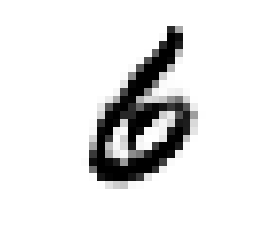

In [13]:
plt.imshow(make_digit(digit=6), cmap='gray_r', interpolation='nearest')
plt.axis('off')